In [2694]:
import pandas as pd
import numpy as np
import ydata_profiling as yp
import janitor
import missingno as msno  
import matplotlib.pyplot as plt
from pathlib import Path
import re
import sklearn

RAW_PATH = "../data/raw/db_computers_2025_raw.csv"

raw_df = pd.read_csv(RAW_PATH, low_memory=False, encoding="utf-8-sig")

### Step 1 – Dataset shape, preview and dtypes
Before we touch anything, let’s confirm how many rows/columns we have, look at the first few records, and see the raw dtypes/missing-value counts.  This gives us a sanity check that the CSV loaded correctly.

In [2695]:
# shape (rows, columns)
print("Shape:", df.shape)

# peek at the first 5 rows
display(df.head())

# dtypes + non-null counts
raw_df.info(show_counts=True)

# rough memory footprint
mem_mb = raw_df.memory_usage(deep=True).sum() / 1e6
print(f"\nMemory usage: {mem_mb:.1f} MB")

Shape: (8054, 130)


,Título,Num_Drives,Sistema operativo_Sistema operativo,Procesador_Nombre en clave del procesador,RAM_Tipo de RAM,Disco duro_Capacidad de memoria SSD,Gráfica_Tarjeta gráfica,Alimentación_Capacidad de la batería,Tipo,Pantalla_Displayglas_flag,...,Eq_Touchpad,Eq_TouchID,Eq_ForceTouch,Eq_SecurityLock,Eq_LiquidCool,Eq_TouchBar,Eq_ScreenPad,Eq_TrackPoint,Eq_Other,Multi_Drive_flag
0,"Apple MacBook Air 13"" 2024 M3",1.0,Unknown,Unknown,Unknown,512.0,Unknown,4800.0,Laptop,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Apple MacBook Air 15"" 2024 M3",1.0,Unknown,Unknown,Unknown,512.0,Unknown,4800.0,Laptop,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Apple MacBook Pro 14"" M4 (2024)",1.0,macOS Sequoia,Unknown,Unknown,512.0,Unknown,4800.0,Laptop,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ASUS TUF Gaming A15 FA506 (2024),1.0,Unknown,Rembrandt-R,DDR5,512.0,Unknown,4800.0,Laptop,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,GigaByte Aero 16 OLED BKF,1.0,Windows 11 Home,Raptor Lake-H,DDR5,1000.0,Unknown,4800.0,Laptop,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8064 entries, 0 to 8063
Columns: 136 entries, Unnamed: 0 to Procesador_Procesadores compatibles
dtypes: float64(10), int64(1), object(125)
memory usage: 8.4+ MB

Memory usage: 47.2 MB


### Step 2 – Drop the auto-increment column and check for duplicates  
The scraper left an `Unnamed: 0` column that’s just a row index; it adds no information.  
After dropping it we’ll count:  
1. Exact duplicate rows (all columns match).  
2. Duplicate product titles, which may hint at variant listings we’ll need to merge later.

In [2696]:
# ------------- 2A. Drop 'Unnamed: 0' if present -------------
if "Unnamed: 0" in raw_df.columns:
    df = raw_df.drop(columns=["Unnamed: 0"])
    print("'Unnamed: 0' column removed.")
else:
    print("No 'Unnamed: 0' column found.")

print("Shape after drop:", df.shape)


# ------------- 2B. Exact-row duplicates -------------
dup_rows = df.duplicated().sum()
print(f"Exact duplicate rows: {dup_rows}")


# ------------- 2C. Duplicate product titles -------------
if "Título" in df.columns:
    dup_titles = df["Título"].duplicated().sum()
    print(f"Duplicate product titles: {dup_titles}")
else:
    print("Column 'Título' not found – skip title-dup check.")

'Unnamed: 0' column removed.
Shape after drop: (8064, 135)
Exact duplicate rows: 10
Duplicate product titles: 11


### Step 2a – Remove exact-row duplicates 🧹  
Exact duplicates add no value (they just add noise); we’ll drop them in-place and confirm the new shape.

### Step 2a – Remove exact-row duplicates   
Exact duplicates add no value; we’ll drop them in-place and confirm the new shape.

In [2697]:
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]

print(f"Rows before: {before}  → after dropping dup rows: {after}")

Rows before: 8064  → after dropping dup rows: 8054


In [2698]:
if "Título" in df.columns:
    dup_titles = df["Título"].duplicated().sum()
    print(f"Duplicate product titles: {dup_titles}")
else:
    print("Column 'Título' not found – skip title-dup check.")

Duplicate product titles: 1


Keep both rows.
•They’re valuable records for a price-prediction model—each row’s Precio_Rango will differ.

### Step 3 – Missing-value heat-map & percent table  
We need to know which columns are sparsely filled so we can decide early whether to drop or impute them.

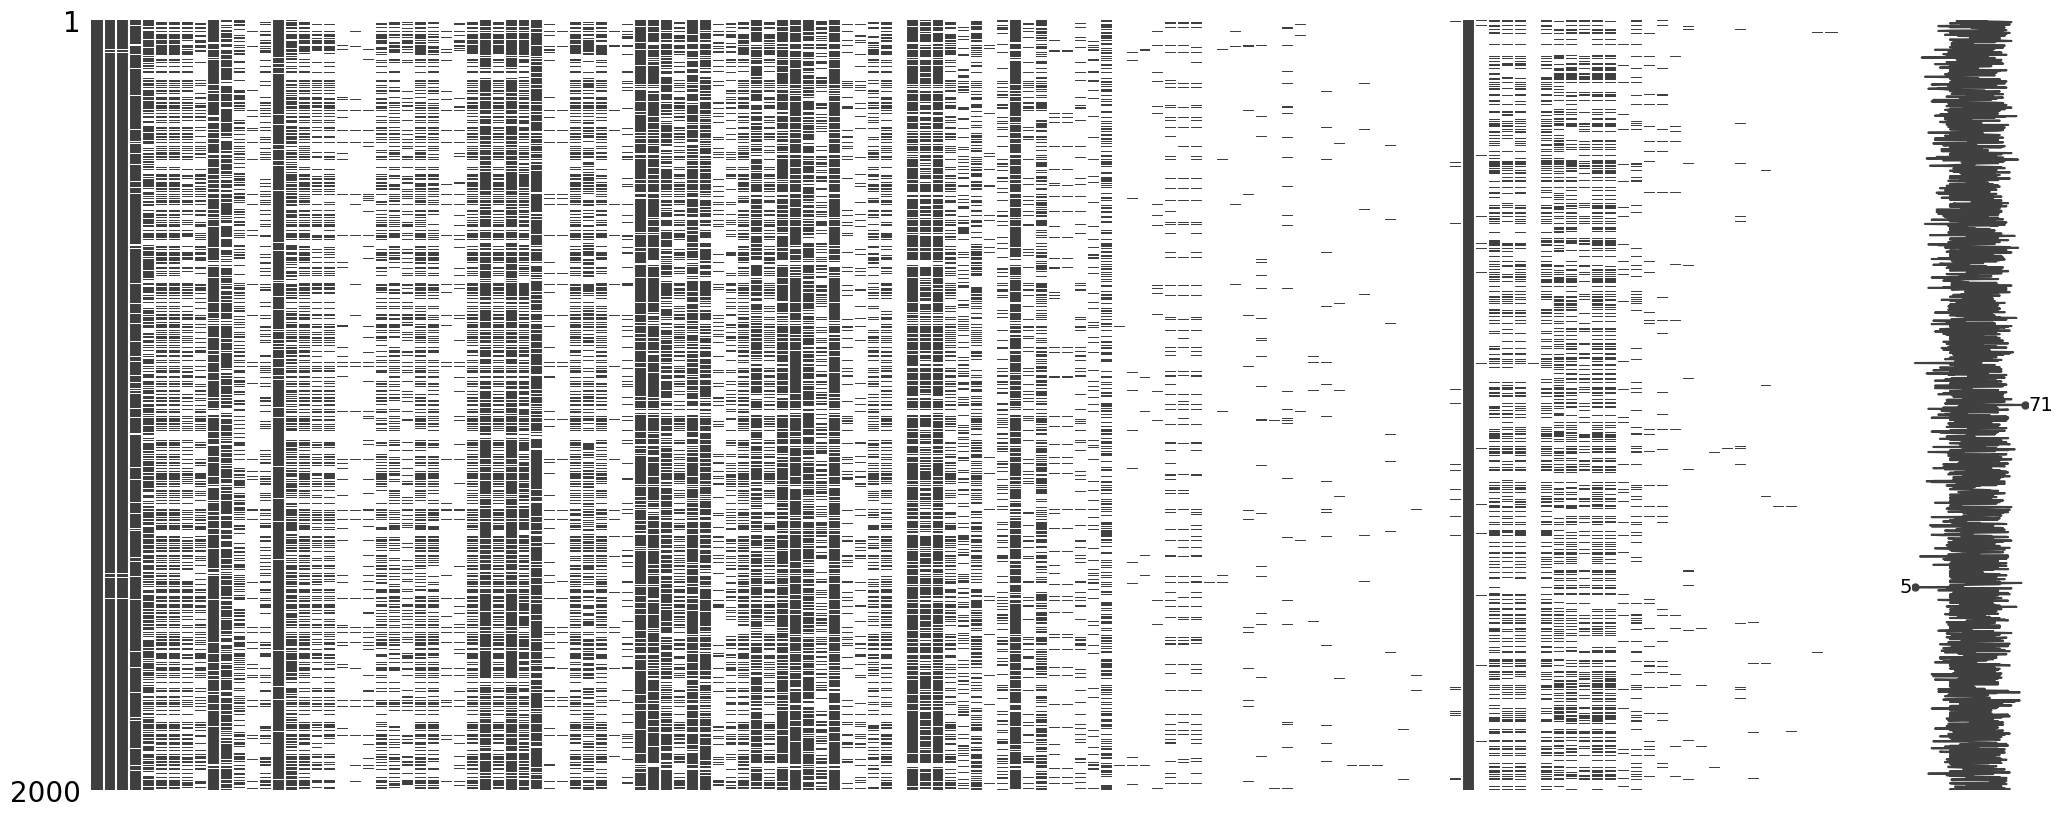

Almacenamiento_Velocidades de lectura         99.975168
Almacenamiento_Velocidades de escritura       99.975168
Procesador_Procesadores compatibles           99.925503
Sistema operativo_Software incluido           99.925503
Otras características_Certificado RoHS        99.913087
                                                ...    
Comunicaciones_Estándar LAN                   57.958778
Sistema operativo_Arquitectura bit            56.543333
Alimentación_Vatios-hora                      54.556742
Pantalla_Formato de imagen                    53.551031
Otras características_Fecha de lanzamiento    53.128880
Length: 100, dtype: float64

In [2699]:
# 3A. Heat-map on a sample (for readability)
msno.matrix(df.sample(min(2000, len(df)), random_state=0))
plt.show()

# 3B. Percent missing per column
na_pct = (df.isna().mean() * 100).sort_values(ascending=False)
na_pct.head(100)

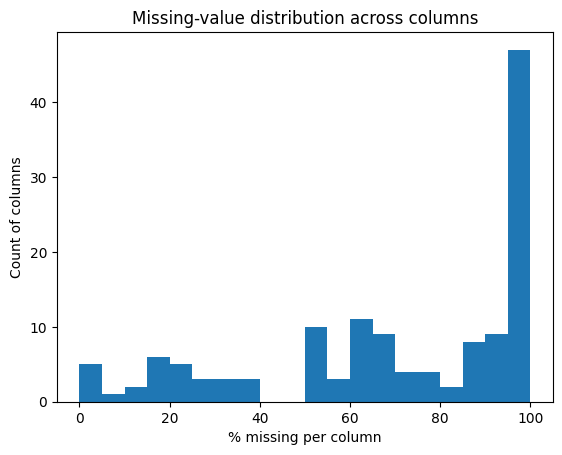

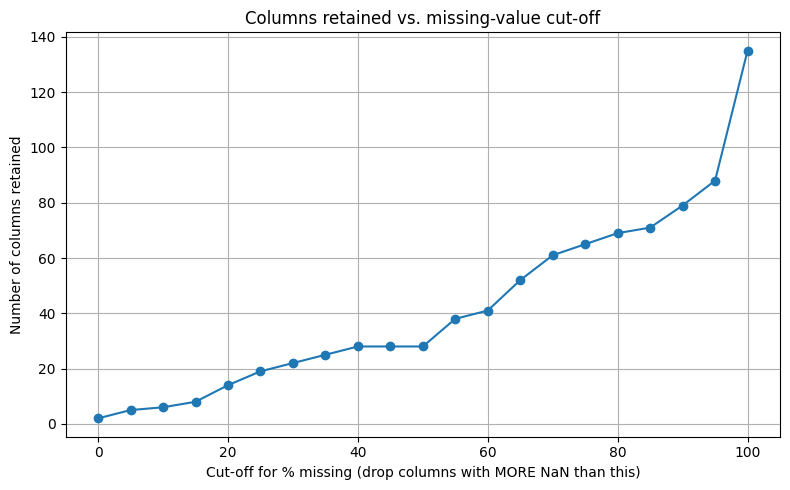

In [2700]:
import textwrap

# -- A. visualise missing-rate distribution ----------------------------
na_pct_series = df.isna().mean().mul(100)
plt.hist(na_pct_series, bins=20)
plt.xlabel("% missing per column"); plt.ylabel("Count of columns")
plt.title("Missing-value distribution across columns")
plt.show()

# -- B. list columns with ≥ 50 % NaN ----------------------------------
audit_cols = na_pct_series[na_pct_series >= 50].sort_values(ascending=False).index

audit = (
    pd.DataFrame({
        "pct_missing": na_pct_series[audit_cols].round(1),
        "unique_vals": df[audit_cols].nunique(dropna=True),
        "sample_values": (
            df[audit_cols]
            .apply(lambda col: col.dropna().unique()[:5])
            .apply(lambda x: [textwrap.shorten(str(v), 25) for v in x])
        ),
    })
)

audit

# 1. Reload the latest dataframe in your notebook context
#    (or read raw CSV again if you've restarted the kernel)
df_plot = df.copy()  # <-  use your in-memory df

# 2. Compute % missing for every column
na_pct = df_plot.isna().mean().mul(100).sort_values()

# 3. Build the “columns retained vs. cut-off” curve
thresholds = np.arange(0, 101, 5)
cols_kept  = [(na_pct <= t).sum() for t in thresholds]

plt.figure(figsize=(8, 5))
plt.plot(thresholds, cols_kept, marker="o")
plt.title("Columns retained vs. missing-value cut-off")
plt.xlabel("Cut-off for % missing (drop columns with MORE NaN than this)")
plt.ylabel("Number of columns retained")
plt.grid(True)
plt.tight_layout()
plt.show()

## Selecting the missing-value cut-off  → **50 % NaN**

### What the plots reveal  

| Plot | Key observations | Interpretation |
|------|------------------|----------------|
| **Histogram of “% NaN per column”** | • Dense cluster of columns below **35 %** missing.<br>• Noticeable gap, then a secondary ridge that starts just **above 50 %** and tails off by 75 %.<br>• A final spike at ~95 %–100 % for the almost-empty “badge” fields. | The gap after 40–50 % cleanly separates “reasonably populated” features from those that are largely empty. |
| **Columns-retained vs. cut-off curve** | • Sharp rise from **0 % → 50 %**—each 5-point step keeps several columns.<br>• **Elbow at 50 %**: the curve flattens; raising the threshold to 55 % gains almost no extra columns.<br>• Second, slower climb after 55 % as we begin adding 60–75 % sparse fields.<br>• Final jump at 100 % would re-introduce the all-NaN placeholders. | **50 % is the natural elbow**—beyond it we pay the cost of extra sparsity with minimal information gain. |

### Decision ✔️ **Set the cut-off at 50 % missing values**

* Drops the “upper-half sparse” block while **retaining every feature present in ≥ 4 000 rows** (half of the 8 054 observations)—ample signal for tree/boosting models.
* Avoids dragging in the 60–75 % sparse group that would bloat preprocessing and invite over-fitting noise.
* Leaves a manageable schema of **≈ 60 columns**—rich enough for modelling yet light for imputation and Streamlit UI.

### Optional safety net

If a sparse column over the 50 % line is genuinely important (e.g. `"Pantalla_Displayglas"` or `"Gráfica_GPU"`), keep its *presence* as a simple **0/1 flag** before dropping the original value:

```python
flag_cols = ["Pantalla_Displayglas", "Gráfica_GPU"]
for col in flag_cols:
    df[col + "_flag"] = (~df[col].isna()).astype(int)

### Handle columns with > 50 % missing values  
We collapse a handful into binary “feature present” flags and drop the rest.

In [2701]:
# --- 3A. identify columns with > 50 % missing --------------------------
na_pct = df.isna().mean() * 100
sparse_50 = na_pct[na_pct > 50].index.tolist()
print(f"Columns >50 % NaN: {len(sparse_50)}")

# --- 3B. curate the keep-lists ----------------------------------------
# numeric spec we still want (parse later)
keep_numeric = ["Alimentación_Capacidad de la batería"]

# sparse fields we keep only as binary “present/absent” flags
keep_flag = ["Pantalla_Displayglas", "Gráfica_GPU"]

# anything else above the 50 % threshold is dropped
drop_cols = [c for c in sparse_50 if c not in keep_numeric + keep_flag]
print(
    f"Keeping {len(keep_numeric)} numeric col(s) "
    f"and {len(keep_flag)} flag(s); dropping {len(drop_cols)} others."
)

# --- 3C. create _flag columns -----------------------------------------
for col in keep_flag:
    if col in df.columns:                       # safety check
        df[col + "_flag"] = (~df[col].isna()).astype(int)

# --- 3D. drop the noise columns ---------------------------------------
df = df.drop(columns=drop_cols)
print("Shape after 50 % sparsity handling:", df.shape)

Columns >50 % NaN: 107
Keeping 1 numeric col(s) and 2 flag(s); dropping 104 others.
Shape after 50 % sparsity handling: (8054, 33)


**Why a cut-off at 50 % missing (dropping 104 columns) is both safe and sensible**

* **> 50 % NaN ⇒ a column is populated in ≤ 4 000 rows out of 8 054 (half the data).**  
  At that coverage level tree/boosting models either ignore the feature (no split gain) or over-fit to a small slice of the dataset.  
  Removing them prevents instability while sacrificing very little signal.

* **The high-sparsity fields are mostly niche or “marketing-badge” specs**  
  (RoHS certificates, odd drive-bay options, verbose Bluetooth details, etc.).  
  They rarely influence price and would only bloat preprocessing for negligible gain.

* **Business-relevant yet sparse information was rescued as compact indicators** – we kept  
  * `Pantalla_Displayglas_flag` – special coated glass present (0/1)  
  * `Gráfica_GPU_flag` – discrete GPU present (0/1)  
  * `Alimentación_Capacidad de la batería` – battery Wh (numeric)  
  Thus any genuine “premium” signal survives without hauling 100 mostly-empty categorical columns through the pipeline.

* **Nothing is lost irreversibly.**  
  The full raw dataframe remains on disk; if later EDA shows a dropped column matters, we can re-introduce it in seconds.  
  For day-to-day experimentation, working on **33 well-populated columns** keeps feature-engineering manageable and model iterations fast.

In [2702]:
dropped = drop_cols  # from the previous step
pd.Series(dropped, name="Dropped ≥50%-NaN cols").to_frame()

,Dropped ≥50%-NaN cols
0,Pantalla_Tamaño de la pantalla
1,Pantalla_Diagonal de la pantalla
2,Pantalla_Tecnología de la pantalla
3,Pantalla_Luminosidad
4,Gráfica_Salida de vídeo
...,...
99,"Propiedades de la carcasa_Bahía externa de 3,5"""
100,Procesador_Placa base
101,Otras características_Certificado RoHS
102,Sistema operativo_Software incluido


In [2703]:
# `drop_cols` was the list we actually removed
dropped_cols = pd.Series(drop_cols, name="Dropped ≥50 %-NaN cols").to_frame()

display(dropped_cols)

# set of dropped columns to analyse which ones to get back
dropped_cols.to_csv("../reports/dropped_cols.csv", index=False)

,Dropped ≥50 %-NaN cols
0,Pantalla_Tamaño de la pantalla
1,Pantalla_Diagonal de la pantalla
2,Pantalla_Tecnología de la pantalla
3,Pantalla_Luminosidad
4,Gráfica_Salida de vídeo
...,...
99,"Propiedades de la carcasa_Bahía externa de 3,5"""
100,Procesador_Placa base
101,Otras características_Certificado RoHS
102,Sistema operativo_Software incluido


In [2704]:
import numpy as np

# 1️⃣  Curated lists -----------------------------------------------------
keep_numeric = [
    "Alimentación_Capacidad de la batería",   # already in df
    "Pantalla_Tamaño de la pantalla",
    "Pantalla_Resolución de pantalla",
    "Alimentación_Autonomía de la batería",
    "Procesador_Frecuencia del reloj",
    "RAM_Frecuencia de la memoria",
]

keep_flag = [
    "Pantalla_Displayglas",        # already in df
    "Gráfica_GPU",                 # already in df
    "Pantalla_Tecnología de la pantalla",
    "Conectividad_Lector de tarjetas",
    "Cámara_Webcam",
]

# 2️⃣  Bring back any missing columns from raw_df ------------------------
for col in keep_numeric + keep_flag:
    if col not in df.columns:                 # only if we dropped it
        df[col] = raw_df.get(col, np.nan)     # add from raw or NaN fallback

# 3️⃣  Create binary flags for the sparse-but-important specs ------------
for col in keep_flag:
    df[col + "_flag"] = (~df[col].isna()).astype(int)

# (Optional) drop the original sparse text columns now that we have flags
df = df.drop(columns=[c for c in keep_flag if c in df.columns])

print("Shape after restoring key columns & flags:", df.shape)

Shape after restoring key columns & flags: (8054, 39)


### Why we rescued these specific high-sparsity columns

| Column (type) | Business / modelling relevance | How we’ll use it |
|---------------|--------------------------------|------------------|
| **Pantalla_Tamaño de la pantalla**<br>(*numeric*) | Screen size (“13.3″”, “15.6″”) is a first-order driver of laptop price and a key filter for users. | Parse inches → float; standard-scale for models. |
| **Pantalla_Resolución de pantalla**<br>(*numeric*) | Full-HD vs 2K vs 4K/Retina carries a well-known premium. | Map to vertical pixel count (1080, 1440, 2160). |
| **Alimentación_Autonomía de la batería**<br>(*numeric*) | Real-world battery life greatly influences value, especially in ultrabooks. | Convert “X h” → float hours; median-impute. |
| **Procesador_Frecuencia del reloj**<br>(*numeric*) | Within the same CPU family, higher base clocks correlate with higher SKUs and price. | Parse “3,2 GHz” → 3.2; scale. |
| **RAM_Frecuencia de la memoria**<br>(*numeric*) | DDR4-3200 vs DDR5-5600 reflects generation and performance tier, impacting price. | Parse “3200 MHz” → 3200. |
| **Alimentación_Capacidad de la batería**<br>(*numeric, already kept*) | Watt-hours is the engineering spec behind battery life; complements the autonomy claim. | Parse “Wh”; keep numeric. |
| **Pantalla_Tecnología de la pantalla**<br>(*flag*) | OLED / IPS / Mini-LED tech commands a surcharge even when sparsely reported. | `Pantalla_Tecnología_flag` (0/1). |
| **Pantalla_Displayglas**<br>(*flag, already kept*) | Presence of special coated / glare-free glass is a premium cue. | `Pantalla_Displayglas_flag` (0/1). |
| **Gráfica_GPU**<br>(*flag, already kept*) | Discrete GPU vs iGPU dramatically shifts price in creator / gaming segments. | `Gráfica_GPU_flag` (0/1). |
| **Conectividad_Lector de tarjetas**<br>(*flag*) | SD-card slot is niche but valued by photographers; absence/presence matters. | `Lector_tarjetas_flag` (0/1). |
| **Cámara_Webcam**<br>(*flag*) | Post-pandemic, built-in webcam absence lowers perceived value—even if sparsely noted. | `Webcam_flag` (0/1). |

These columns are sparse (> 50 % NaN) but **carry clear price-signal or usability impact**.  
By parsing the numeric ones and collapsing the rest into binary flags we:

* Preserve critical information without re-introducing 100 near-empty text fields.  
* Keep the working dataframe compact (~40–45 columns), easing imputation and model interpretability.  
* Maintain flexibility: the raw text remains on disk, so we can enrich or refine these features later if needed.

**Dataset checkpoint after cutoff**

In [2705]:
from datetime import datetime

# 1️⃣  Save the current slimmed-down dataframe --------------------------
OUT_CSV = Path("../data/processed/eda_after_50pct_cutoff.csv")
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print(f"CSV written to {OUT_CSV} — shape {df.shape}")

# 2️⃣  Find object columns that still contain digits -------------------
def looks_numeric(series: pd.Series) -> bool:
    return series.str.contains(r"\d", na=False).any()

obj_cols = df.select_dtypes(include="object").columns
parse_candidates = [c for c in obj_cols if looks_numeric(df[c])]

print(f"\nColumns likely needing numeric parsing: {len(parse_candidates)} found.")

# 3️⃣  Save the candidate list to reports/ -----------------------------
REPORTS_DIR = Path("../reports")
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

cand_df = pd.DataFrame(parse_candidates, columns=["parse_candidates"])
cand_file = REPORTS_DIR / "parse_candidates.csv"
cand_df.to_csv(cand_file, index=False, encoding="utf-8-sig")

print(f"Candidate list saved to {cand_file}")

CSV written to ../data/processed/eda_after_50pct_cutoff.csv — shape (8054, 39)

Columns likely needing numeric parsing: 29 found.
Candidate list saved to ../reports/parse_candidates.csv


Numeric columns that probably need parsing:

parse_candidates
Título
Precio_Rango
Ofertas
Tipo de producto
Serie
Procesador_Procesador
Disco duro_Tipo de disco duro
Comunicaciones_Versión Bluetooth
Medidas y peso_Profundidad
Medidas y peso_Ancho
Medidas y peso_Peso
Procesador_Tipo de procesador
Gráfica_Memoria gráfica
Sistema operativo_Sistema operativo
Procesador_Nombre en clave del procesador
Procesador_Caché
RAM_Memoria RAM
RAM_Tipo de RAM
Disco duro_Capacidad de memoria SSD
Procesador_Número de núcleos del procesador
Procesador_Frecuencia de reloj
Procesador_Frecuencia turbo máx.
Gráfica_Tarjeta gráfica
Alimentación_Capacidad de la batería
Pantalla_Tamaño de la pantalla
Pantalla_Resolución de pantalla
Alimentación_Autonomía de la batería
Procesador_Frecuencia del reloj
RAM_Frecuencia de la memoria

## PARSING

**1  Parse the target: Precio_Rango → Precio_min / Precio_max / Precio_avg**

In [2706]:
def _euro_to_float(txt: str) -> float:
    return float(txt.replace('.', '').replace(',', '.'))

def _parse_price_range(val):
    """Return (min€, max€) from Spanish '1.026,53 € – 2.287,17 €'."""
    if pd.isna(val):
        return np.nan, np.nan
    text = str(val)                         # <-- make sure it's a str
    nums = re.findall(r'([\d\.]+,\d{2})', text)
    if len(nums) == 2:
        return _euro_to_float(nums[0]), _euro_to_float(nums[1])
    if len(nums) == 1:
        v = _euro_to_float(nums[0]);  return v, v
    return np.nan, np.nan

df[['Precio_min', 'Precio_max']] = (
    df['Precio_Rango']
      .apply(_parse_price_range)
      .apply(pd.Series)
)
df['Precio_avg'] = df[['Precio_min', 'Precio_max']].mean(axis=1)

df[['Precio_Rango', 'Precio_min', 'Precio_max', 'Precio_avg']].head()

,Precio_Rango,Precio_min,Precio_max,Precio_avg
0,"1.026,53 € – 2.287,17 €",1026.53,2287.17,1656.850
1,"1.270,42 € – 2.672,25 €",1270.42,2672.25,1971.335
2,"1.731,44 € – 4.932,25 €",1731.44,4932.25,3331.845
3,"647,00 € – 1.031,71 €",647.00,1031.71,839.355
4,"1.031,31 € – 2.069,99 €",1031.31,2069.99,1550.650


**2  Screen specs**

**3  Battery specs**

**CPU & RAM frequencies**

**6  Physical dimensions & weight**

In [2707]:
# Depth, Width, Height (mm) – they appear with commas
import re, numpy as np, pandas as pd

dim_pat = re.compile(r'([\d,\.]+)')   # grabs the numeric part

def parse_dimension(text, to_mm=True):
    """
    Extract the numeric value and convert:
    • '21.5 cm'  ->  215   (mm)  if to_mm
    • '350 mm'   ->  350   (mm)
    • '1,9 cm'   ->  19    (mm)
    • NaN        ->  np.nan
    """
    if pd.isna(text):
        return np.nan
    s = str(text).replace('\xa0', ' ')            # kill NBSP
    num_match = dim_pat.search(s)
    if not num_match:
        return np.nan
    val = float(num_match.group(1).replace(',', '.'))
    if not to_mm:
        return val                                # leave as is
    if 'cm' in s.lower():
        return val * 10                           # 1 cm = 10 mm
    return val                                    # already mm

def parse_weight(text):
    """
    • '2,2 kg'  -> 2.2
    • '780 g'   -> 0.78
    """
    if pd.isna(text):
        return np.nan
    s = str(text).replace('\xa0', ' ')
    num_match = dim_pat.search(s)
    if not num_match:
        return np.nan
    val = float(num_match.group(1).replace(',', '.'))
    s_lower = s.lower()
    if 'kg' in s_lower:
        return val           # already kilograms
    if 'g' in s_lower:
        return val / 1000    # grams → kg
    return val               # fallback

# apply
df['Profundidad_mm'] = df['Medidas y peso_Profundidad'].map(parse_dimension)
df['Ancho_mm']       = df['Medidas y peso_Ancho'].map(parse_dimension)
df['Peso_kg']        = df['Medidas y peso_Peso'].map(parse_weight)

df[['Medidas y peso_Profundidad', 'Profundidad_mm',
    'Medidas y peso_Peso',        'Peso_kg']].head()

,Medidas y peso_Profundidad,Profundidad_mm,Medidas y peso_Peso,Peso_kg
0,"21,5 cm",215.0,"1,24 kg",1.24
1,"23,8 cm",238.0,"1,51 kg",1.51
2,"22,1 cm",221.0,"1,6 kg",1.60
3,"25,6 cm",256.0,"2,3 kg",2.30
4,"25,5 cm",255.0,"1,9 kg",1.90


**7 Ofertas**

In [2708]:
# 1. Extract the number of offers and convert to numeric
df['Ofertas_num'] = (
    df['Ofertas']
      .str.extract(r'(\d+)', expand=False)   # grab the digits
      .astype(float)                        # convert to float (or int if you prefer)
      .fillna(0)                            # if there’s no match, assume zero offers
)

# 2. Drop the original text column
df.drop(columns=['Ofertas'], inplace=True)

# 3. Verify
df[['Ofertas_num']].head()

,Ofertas_num
0,200.0
1,230.0
2,136.0
3,30.0
4,29.0


**Cache of processor**

In [2709]:
import re
import numpy as np

def parse_cache_mb(text):
    """
    Extracts the cache size in MB from strings like "12 MB" or returns NaN for unknown.
    """
    if pd.isna(text):
        return np.nan
    s = str(text).replace('\xa0', ' ').strip()
    # if it says unknown (case-insensitive), treat as NaN
    if 'unknown' in s.lower():
        return np.nan
    # find the number (with comma or dot)
    m = re.search(r'([\d.,]+)', s)
    if not m:
        return np.nan
    # normalize and convert
    num = m.group(1).replace(',', '.')
    try:
        return float(num)
    except ValueError:
        return np.nan

# Apply the parser
df['Cache_MB'] = df['Procesador_Caché'].map(parse_cache_mb)

# Drop the original text column
df.drop(columns=['Procesador_Caché'], inplace=True)

# Verify
df[['Cache_MB']].head()

,Cache_MB
0,NaN
1,NaN
2,NaN
3,16.0
4,24.0


**RAM GB**

In [2710]:
def parse_ram_gb(text):
    """
    Extracts RAM size in GB from strings like "16 GB" or "8192 MB".
    Returns NaN for 'Unknown' or unparsable.
    """
    if pd.isna(text):
        return np.nan
    s = str(text).replace('\xa0', ' ').strip().lower()
    if 'unknown' in s:
        return np.nan
    # find the numeric part (allow comma or dot)
    m = re.search(r'([\d.,]+)', s)
    if not m:
        return np.nan
    num = m.group(1).replace(',', '.')
    try:
        val = float(num)
    except ValueError:
        return np.nan
    # convert units
    if 'mb' in s:
        return val / 1024.0
    # assume GB if mention or no unit
    return val

# Apply the parser
df['RAM_GB'] = df['RAM_Memoria RAM'].map(parse_ram_gb)

# Drop the original text column
df.drop(columns=['RAM_Memoria RAM'], inplace=True)

# Verify
df[['RAM_GB']].head()

,RAM_GB
0,NaN
1,NaN
2,NaN
3,16.0
4,16.0


**SSD Capacity**

In [2711]:
import re
import numpy as np

def parse_ssd_capacity(text):
    """
    Convert values like:
      - "512 GB"      -> 512.0
      - "1.000 GB"    -> 1000.0
      - "1 TB" or "1 T" -> 1000.0
      - "Unknown"     -> np.nan
    Handles Spanish formatting: dot=thousands sep, comma=decimal sep.
    """
    if pd.isna(text):
        return np.nan
    s = str(text).strip().lower().replace('\xa0', ' ')
    if 'unknown' in s:
        return np.nan

    # Extract the numeric part
    m = re.search(r'[\d\.,]+', s)
    if not m:
        return np.nan
    num_str = m.group(0)

    # If there is a comma, treat dots as thousands and comma as decimal
    if ',' in num_str:
        num_str = num_str.replace('.', '').replace(',', '.')
    else:
        # No comma: remove all dots (they are thousands separators)
        num_str = num_str.replace('.', '')

    try:
        val = float(num_str)
    except ValueError:
        return np.nan

    # Convert TB (terabytes) to GB (1 TB = 1000 GB)
    if re.search(r'\b(t|tb)\b', s):
        val *= 1000.0

    return val

# Apply in-place on the original column
df['Disco duro_Capacidad de memoria SSD'] = (
    df['Disco duro_Capacidad de memoria SSD']
      .map(parse_ssd_capacity)
)

# Verify the parsing
df['Disco duro_Capacidad de memoria SSD'].head(10)

0       NaN
1       NaN
2       NaN
3     512.0
4    1000.0
5     512.0
6    1000.0
7    1000.0
8       NaN
9       NaN
Name: Disco duro_Capacidad de memoria SSD, dtype: float64

**Number of cores**

In [2712]:
def parse_num_cores(text):
    """
    Extracts the number of CPU cores from strings like:
      - "4 núcleos"    -> 4
      - "6 cores"      -> 6
      - "Quad-core"    -> 4
      - "Hexa-core"    -> 6
      - NaN or unparsable -> np.nan
    """
    if pd.isna(text):
        return np.nan
    s = str(text).lower()
    # 1️⃣ Try to find an explicit digit
    m = re.search(r'(\d+)', s)
    if m:
        return int(m.group(1))
    # 2️⃣ Fallback on common prefixes
    prefixes = {
        'dual': 2,
        'quad': 4,
        'hexa': 6,
        'octa': 8,
        'deca': 10
    }
    for prefix, val in prefixes.items():
        if prefix in s:
            return val
    return np.nan

# Apply the parser
df['Procesador_Cores'] = df['Procesador_Número de núcleos del procesador'].map(parse_num_cores)

# Drop the original text column
df.drop(columns=['Procesador_Número de núcleos del procesador'], inplace=True)

# Verify
df[['Procesador_Cores']].head()

,Procesador_Cores
0,NaN
1,NaN
2,NaN
3,NaN
4,14.0


**CPU Frequency**

In [2713]:
def parse_cpu_freq(text):
    """
    Extracts CPU base frequency in GHz from strings such as:
      - "3,2 GHz"   -> 3.2
      - "2.50 GHz"  -> 2.5
      - "3200 MHz"  -> 3.2
      - "Unknown"   -> np.nan
    """
    if pd.isna(text):
        return np.nan
    s = str(text).strip().lower()
    if 'unknown' in s:
        return np.nan

    # Find the numeric part
    m = re.search(r'[\d\.,]+', s)
    if not m:
        return np.nan
    num_str = m.group(0)
    
    # Handle European formatting: comma=decimal, dot=thousands
    if ',' in num_str:
        num_str = num_str.replace('.', '').replace(',', '.')
    else:
        num_str = num_str  # keep dot as decimal if present

    try:
        val = float(num_str)
    except ValueError:
        return np.nan

    # Convert MHz to GHz if indicated
    if 'mhz' in s:
        val = val / 1000.0

    return val

# Apply the parser
df['CPU_GHz'] = df['Procesador_Frecuencia de reloj'].map(parse_cpu_freq)

# Drop the original text column
df.drop(columns=['Procesador_Frecuencia del reloj'], inplace=True)
df.drop(columns=['Procesador_Frecuencia de reloj'], inplace=True)

# Verify
df[['CPU_GHz']].head()

,CPU_GHz
0,NaN
1,NaN
2,NaN
3,NaN
4,1.8


**CPU Turbo Frequency Max**

In [2714]:
def parse_cpu_turbo(text):
    """
    Extracts the maximum turbo frequency in GHz from strings such as:
      - "4,7 GHz"   -> 4.7
      - "4.20 GHz"  -> 4.2
      - "Unknown"   -> np.nan
    """
    if pd.isna(text):
        return np.nan
    s = str(text).strip().lower()
    if 'unknown' in s:
        return np.nan

    # Find the numeric part
    m = re.search(r'[\d\.,]+', s)
    if not m:
        return np.nan
    num_str = m.group(0)

    # Handle European formatting: comma=decimal, strip thousand dots
    if ',' in num_str:
        num_str = num_str.replace('.', '').replace(',', '.')
    # else keep dot as decimal

    try:
        val = float(num_str)
    except ValueError:
        return np.nan

    return val

# Apply the parser
df['CPU_Turbo_GHz'] = df['Procesador_Frecuencia turbo máx.'].map(parse_cpu_turbo)

# Drop the original text column
df.drop(columns=['Procesador_Frecuencia turbo máx.'], inplace=True)

# Verify
df[['CPU_Turbo_GHz']].head()

,CPU_Turbo_GHz
0,NaN
1,NaN
2,NaN
3,NaN
4,5.0


**Battery Capacity**

In [2715]:
def parse_battery_capacity(text):
    """
    Extracts battery capacity in Wh from strings like:
      - "56 Wh"     -> 56.0
      - "1.000 Wh"  -> 1000.0
      - "Unknown"   -> np.nan
    """
    if pd.isna(text):
        return np.nan
    s = str(text).strip().lower().replace('\xa0', ' ')
    if 'unknown' in s:
        return np.nan

    # extract the first numeric group
    m = re.search(r'[\d\.,]+', s)
    if not m:
        return np.nan
    num_str = m.group(0)

    # Spanish formatting: dot=thousands sep, comma=decimal sep
    if ',' in num_str:
        num_str = num_str.replace('.', '').replace(',', '.')
    else:
        num_str = num_str.replace('.', '')

    try:
        return float(num_str)
    except ValueError:
        return np.nan

# Apply parser in-place
df['Alimentación_Capacidad de la batería'] = (
    df['Alimentación_Capacidad de la batería']
      .map(parse_battery_capacity)
)

# Verify
df[['Alimentación_Capacidad de la batería']].head()

,Alimentación_Capacidad de la batería
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


**Screen Size**

In [2716]:

def parse_screen_size(text):
    """
    Converts strings like "13,3 pulgadas" -> 13.3.
    Assumes no thousands separators, only comma as decimal.
    """
    if pd.isna(text):
        return np.nan
    s = str(text).strip().lower()
    # extract the numeric part (digits, a comma or dot, then digits)
    m = re.search(r'(\d+[\.,]\d+|\d+)', s)
    if not m:
        return np.nan
    num_str = m.group(0).replace(',', '.')
    try:
        return float(num_str)
    except ValueError:
        return np.nan

# Apply the parser
df['Pantalla_Tamaño_pulg'] = df['Pantalla_Tamaño de la pantalla'].map(parse_screen_size)

# Drop the original text column
df.drop(columns=['Pantalla_Tamaño de la pantalla'], inplace=True)

# Verify
df[['Pantalla_Tamaño_pulg']].head()

,Pantalla_Tamaño_pulg
0,13.6
1,15.3
2,14.2
3,15.6
4,16.0


**Screen Resolution**

In [2717]:
# 1️⃣ Reload the original “Pantalla_Resolución de pantalla” from your raw CSV
#    so you haven’t lost it by a previous drop.
RAW_PATH = "../data/raw/db_computers_2025_raw.csv"
raw_df = pd.read_csv(RAW_PATH, low_memory=False, encoding="utf-8-sig")

# 2️⃣ Pull in the raw resolution text
col = "Pantalla_Resolución de pantalla"
df[col] = raw_df[col]

# 3️⃣ Extract the two numbers (handling “3.024 x 1.964 píxeles” → “3024” & “1964”)
pattern = r'([\d\.]+)\s*[×xX]\s*([\d\.]+)'
matches = df[col].astype(str).str.extract(pattern)

# 4️⃣ Remove the dot thousands‐seps and convert to float (leave NaNs for no match)
h = matches[0].str.replace('.', '', regex=False).astype(float)
v = matches[1].str.replace('.', '', regex=False).astype(float)

# 5️⃣ Assign to new columns
df['Res_Horiz_px'] = h
df['Res_Vert_px']  = v

# 6️⃣ Drop the original text column
df.drop(columns=[col], inplace=True)

# 7️⃣ Quick sanity check
print(df[['Res_Horiz_px','Res_Vert_px']].head())

   Res_Horiz_px  Res_Vert_px
0           NaN          NaN
1           NaN          NaN
2        3024.0       1964.0
3        1920.0       1080.0
4           NaN          NaN


**Battery Hours**

In [2718]:
def parse_battery_hours(text):
    """
    Converts strings like:
      - "8 h"        -> 8.0
      - "10,5 horas" -> 10.5
      - "Unknown"    -> np.nan
    Handles Spanish formatting: dot=thousands (rare here), comma=decimal.
    """
    if pd.isna(text):
        return np.nan
    s = str(text).strip().lower().replace('\xa0', ' ')
    if 'unknown' in s:
        return np.nan
    # extract the first number (allows comma or dot)
    m = re.search(r'([\d\.,]+)', s)
    if not m:
        return np.nan
    num_str = m.group(1).replace('.', '').replace(',', '.')
    try:
        return float(num_str)
    except ValueError:
        return np.nan

# Apply the parser
df['Bateria_Autonomia_h'] = df['Alimentación_Autonomía de la batería'].map(parse_battery_hours)

# Drop the original text column
df.drop(columns=['Alimentación_Autonomía de la batería'], inplace=True)

# Verify
df[['Bateria_Autonomia_h']].head()

,Bateria_Autonomia_h
0,15.0
1,15.0
2,13.0
3,NaN
4,NaN


**RAM Frequency**

In [2719]:
def parse_ram_freq(text):
    """
    Extracts RAM frequency in MHz from strings such as:
      - "3 200 MHz"   -> 3200.0
      - "3200 MHz"    -> 3200.0
      - "DDR4-3200"   -> 3200.0
      - "Unknown"     -> np.nan
    Handles Spanish formatting: dot=thousands sep, comma=decimal sep.
    """
    if pd.isna(text):
        return np.nan
    s = str(text).strip().lower().replace('\xa0', ' ')
    if 'unknown' in s:
        return np.nan
    # find the first numeric group
    m = re.search(r'[\d\.,]+', s)
    if not m:
        return np.nan
    num_str = m.group(0)
    # if comma present, treat dot as thousands, comma as decimal
    if ',' in num_str:
        num_str = num_str.replace('.', '').replace(',', '.')
    else:
        # no comma: remove all dots (thousands separators)
        num_str = num_str.replace('.', '')
    try:
        return float(num_str)
    except ValueError:
        return np.nan

# Apply the parser
df['RAM_MHz'] = df['RAM_Frecuencia de la memoria'].map(parse_ram_freq)

# Drop the original text column
df.drop(columns=['RAM_Frecuencia de la memoria'], inplace=True)

# Verify
df[['RAM_MHz']].head()

,RAM_MHz
0,NaN
1,NaN
2,NaN
3,5600.0
4,NaN


**GPU Memory**

In [2720]:
col = "Gráfica_Memoria gráfica"   # original raw column

def parse_gpu_mem(text):
    """
    Returns a tuple (memory_gb, shared_flag)

    Handles cases:
      • "8.192 MB"                 -> (8.192/1024)  = 8.0 GB, 0
      • "8.192 MB / 8 GB"          -> (8.0)         = 8.0 GB, 0
      • "8 GB"                     -> (8.0) GB, 0
      • "memoria compartida"       -> (np.nan, 1)
      • "Unknown" / NaN            -> (np.nan, 0)
    """
    # default
    shared_flag = 0
    if pd.isna(text):
        return np.nan, shared_flag

    s = str(text).lower().replace('\xa0', ' ').strip()

    # Detect shared-memory tag
    if "memoria compartida" in s:
        return np.nan, 1

    # Unknown → leave NaN
    if "unknown" in s:
        return np.nan, shared_flag

    # Keep only part before any slash ("/")
    s = s.split("/")[0].strip()

    # Capture first numeric token and its unit (mb/gb)
    m = re.search(r'([\d\.,]+)\s*(gb|mb)', s)
    if not m:
        return np.nan, shared_flag

    num, unit = m.groups()
    # Spanish format: dot = thousands separator, comma = decimal
    if ',' in num:
        num = num.replace('.', '').replace(',', '.')
    else:
        num = num.replace('.', '')  # remove thousands

    try:
        val = float(num)
    except ValueError:
        return np.nan, shared_flag

    # MB → GB conversion
    if unit == "mb":
        val /= 1024.0

    return val, shared_flag

# Apply the parser into two new columns
parsed = df[col].apply(parse_gpu_mem)
df["GPU_Memory_GB"]     = parsed.apply(lambda t: t[0])
df["GPU_Shared_Memory_flag"]   = parsed.apply(lambda t: t[1]).astype(int)

# Drop the original text column
df.drop(columns=[col], inplace=True)

# Quick check
print(df[["GPU_Memory_GB", "GPU_Shared_Memory_flag"]].head())

   GPU_Memory_GB  GPU_Shared_Memory_flag
0            NaN                       0
1            NaN                       0
2            NaN                       1
3            NaN                       0
4            8.0                       0


In [2721]:
# 1. Strip whitespace from all column names (just in case)
df.columns = df.columns.str.strip()

# 2. Define the list of original string columns you want to drop
cols_to_drop = [
    "Precio_Rango",
    "Medidas y peso_Profundidad",
    "Medidas y peso_Ancho",
    "Medidas y peso_Peso"
]

# 3. Filter to only those actually in df
existing = [c for c in cols_to_drop if c in df.columns]
print("Columns to drop:", existing)

# 4. Drop them in place
df.drop(columns=existing, inplace=True)
print("New shape after drop:", df.shape)

Columns to drop: ['Precio_Rango', 'Medidas y peso_Profundidad', 'Medidas y peso_Ancho', 'Medidas y peso_Peso']
New shape after drop: (8054, 42)


In [2722]:
display(df.head())

,Título,Tipo de producto,Serie,Procesador_Procesador,Disco duro_Tipo de disco duro,Comunicaciones_Conectividad,Comunicaciones_Versión Bluetooth,Otras características_Equipamiento,Procesador_Fabricante del procesador,Procesador_Tipo de procesador,...,Procesador_Cores,CPU_GHz,CPU_Turbo_GHz,Pantalla_Tamaño_pulg,Res_Horiz_px,Res_Vert_px,Bateria_Autonomia_h,RAM_MHz,GPU_Memory_GB,GPU_Shared_Memory_flag
0,"Apple MacBook Air 13"" 2024 M3",Portátil multimedia,Apple MacBook Air,Apple M3,SSD,"wifi, Bluetooth",Bluetooth 5.3,"micrófono integrado, USB-C, Touchpad multitáct...",NaN,NaN,...,NaN,NaN,NaN,13.6,NaN,NaN,15.0,NaN,NaN,0
1,"Apple MacBook Air 15"" 2024 M3",Portátil multimedia,Apple MacBook Air,Apple M3,SSD,"wifi, Bluetooth",Bluetooth 5.3,"micrófono integrado, USB-C, Touchpad multitáct...",NaN,NaN,...,NaN,NaN,NaN,15.3,NaN,NaN,15.0,NaN,NaN,0
2,"Apple MacBook Pro 14"" M4 (2024)",Portátil multimedia,Apple MacBook Pro,NaN,SSD,"Bluetooth, wifi",Bluetooth 5.3,"USB-C, altavoces estéreo, Touch ID, lector de ...",Apple,Apple M,...,NaN,NaN,NaN,14.2,3024.0,1964.0,13.0,NaN,NaN,1
3,ASUS TUF Gaming A15 FA506 (2024),Portátil gaming,ASUS TUF Gaming,NaN,SSD,"LAN, Bluetooth, wifi",Bluetooth 5.2,"altavoces estéreo, micrófono integrado, USB-C,...",NaN,NaN,...,NaN,NaN,NaN,15.6,1920.0,1080.0,NaN,5600.0,NaN,0
4,GigaByte Aero 16 OLED BKF,Portátil gaming,Gigabyte Aero,Intel Core i7-13700H,SSD,"wifi, Bluetooth",Bluetooth 5.2,"USB-C, altavoces estéreo, lector de tarjetas, ...",Intel,Intel Core i7,...,14.0,1.8,5.0,16.0,NaN,NaN,NaN,NaN,8.0,0


In [2723]:
# 2.1  Save the current dataframe with numeric columns parsed
OUT_CSV = Path("../data/processed/eda_after_numeric_parsing.csv")
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print(f"CSV written to {OUT_CSV} — shape {df.shape}")

CSV written to ../data/processed/eda_after_numeric_parsing.csv — shape (8054, 42)


In [2724]:
# Re-check dtypes
print(df.dtypes.value_counts())

# A. any object columns that still contain digits (likely numeric-in-disguise)
obj_cols = df.select_dtypes(include="object").columns
digitish = [c for c in obj_cols if df[c].str.contains(r"\d", na=False).any()]
print("\nObject columns with digits still inside:")
for c in digitish:
    print(" •", c)

# B. any numeric columns that still have many NaN (decide if you impute or drop later)
nan_report = df.isna().mean().sort_values(ascending=False)
print("\nColumns with >20 % NaN after parsing:")
print(nan_report[nan_report > 0.20].head(15))

float64    21
object     15
int64       6
Name: count, dtype: int64

Object columns with digits still inside:
 • Título
 • Tipo de producto
 • Serie
 • Procesador_Procesador
 • Disco duro_Tipo de disco duro
 • Comunicaciones_Versión Bluetooth
 • Procesador_Tipo de procesador
 • Sistema operativo_Sistema operativo
 • Procesador_Nombre en clave del procesador
 • RAM_Tipo de RAM
 • Gráfica_Tarjeta gráfica

Columns with >20 % NaN after parsing:
Alimentación_Capacidad de la batería              0.984356
Bateria_Autonomia_h                               0.785572
GPU_Memory_GB                                     0.685622
RAM_MHz                                           0.643159
Res_Horiz_px                                      0.586168
Res_Vert_px                                       0.586168
Pantalla_Tamaño_pulg                              0.501490
Comunicaciones_Versión Bluetooth                  0.386640
Peso_kg                                           0.379687
Serie                   

## CATEGORICAL ENCODING

**Binary**

In [2725]:
flag_cols = ['Pantalla_Displayglas_flag', 'Gráfica_GPU_flag',
             'Pantalla_Tecnología de la pantalla_flag',
             'Conectividad_Lector de tarjetas_flag',
             'Cámara_Webcam_flag']
# (These are already 0/1; just verify no NaN)

Extracting **`Brand`** from `Título` and encoding it

Since every product title begins with the brand name (e.g. “Apple MacBook Air…”, “Dell XPS…”, “ASUS TUF…”), we can:

1. **Create a new `Brand` column** by taking the first word of each title.  
2. **Group rare brands** into “Other” (e.g. any brand with < 50 products).  
3. **One-hot encode** the resulting brand categories (or frequency-encode if you prefer a single number).

This lets us keep the full `Título` text for reference while explicitly modeling the brand effect.

In [2726]:
# 1️⃣  Extract the brand as the first token
df['Brand'] = df['Título'].str.split().str[0]

# 2️⃣  Group rare brands into "Other"
brand_counts = df['Brand'].value_counts()
common_brands = brand_counts[brand_counts >= 50].index  # threshold can be tuned
df['Brand_grouped'] = df['Brand'].where(df['Brand'].isin(common_brands), 'Other')

# 3️⃣  One-hot encode the grouped brand
brand_dummies = pd.get_dummies(
    df['Brand_grouped'], prefix='Brand', dtype='int8'
)
df = pd.concat([df, brand_dummies], axis=1)

# 4️⃣  (Optional) drop the helper grouping column but KEEP the original Title
df.drop(columns=['Brand_grouped'], inplace=True)

# 5️⃣  Verify
print("Brands kept:", common_brands.tolist())
print("New one-hot brand columns:", brand_dummies.columns.tolist())
print("Shape after brand encoding:", df.shape)

Brands kept: ['HP', 'Lenovo', 'ASUS', 'Vibox', 'MSI', 'Acer', 'Dell', 'Apple', 'Captiva', 'Sedatech', 'Actina', 'Microsoft', 'VIST', 'Zone', 'Medion', 'Samsung', 'GigaByte', 'LG', 'Intel', 'Ankermann', 'Minisforum', 'PcCom']
New one-hot brand columns: ['Brand_ASUS', 'Brand_Acer', 'Brand_Actina', 'Brand_Ankermann', 'Brand_Apple', 'Brand_Captiva', 'Brand_Dell', 'Brand_GigaByte', 'Brand_HP', 'Brand_Intel', 'Brand_LG', 'Brand_Lenovo', 'Brand_MSI', 'Brand_Medion', 'Brand_Microsoft', 'Brand_Minisforum', 'Brand_Other', 'Brand_PcCom', 'Brand_Samsung', 'Brand_Sedatech', 'Brand_VIST', 'Brand_Vibox', 'Brand_Zone']
Shape after brand encoding: (8054, 66)


**PRODUCT TYPE**

In [2727]:
# Quick glance at cardinality
print("Unique values in 'Tipo de producto':")
print(df['Tipo de producto'].value_counts(dropna=False))

Unique values in 'Tipo de producto':
Tipo de producto
Portátil multimedia     1929
PC gaming               1789
Portátil profesional     808
Portátil gaming          777
Mini PC                  666
PC de oficina            619
NaN                      544
Workstation              276
Portátil convertible     267
PC multimedia            174
Chromebook                76
Barebone                  63
Thin Client               25
Ultrabook                 16
PC completo               12
Netbook                    7
Portátil 3D                3
Kit ampliación PC          3
Name: count, dtype: int64


Seventeen levels is still manageable for one-hot, but eight of them occur fewer than **100** times.  
To keep the feature space compact — and avoid sparse dummies for micro-classes like “Portátil 3D” (n=3) — we will:

1. **Group rare classes (< 100 rows) into “Other”.**  
2. **One-hot encode** the resulting 10 categories.  
3. Keep an explicit “Unknown” dummy so missing stays informative.

In [2728]:
# 1️⃣  Copy the column and fill NaN with "Unknown"
col = 'Tipo de producto'
tmp = df[col].fillna('Unknown')

# 2️⃣  Group rare categories (<100) into "Other"
value_counts = tmp.value_counts()
rare_mask = tmp.isin(value_counts[value_counts < 100].index)
tmp = tmp.where(~rare_mask, 'Other')

# 3️⃣  One-hot encode (keep all dummies; tree models are fine)
dummies = pd.get_dummies(tmp, prefix='Tipo', dtype='int8')

# 4️⃣  Concatenate and drop originals
df = pd.concat([df, dummies], axis=1)
df.drop(columns=[col], inplace=True)

print("Added one-hot columns:", list(dummies.columns))
print("New shape:", df.shape)

Added one-hot columns: ['Tipo_Mini PC', 'Tipo_Other', 'Tipo_PC de oficina', 'Tipo_PC gaming', 'Tipo_PC multimedia', 'Tipo_Portátil convertible', 'Tipo_Portátil gaming', 'Tipo_Portátil multimedia', 'Tipo_Portátil profesional', 'Tipo_Unknown', 'Tipo_Workstation']
New shape: (8054, 76)


**SERIES**

In [2729]:
# Quick glance at cardinality
print("Unique values in 'Series':")
print(df['Serie'].value_counts(dropna=False))

Unique values in 'Series':
Serie
NaN                   2895
Lenovo ThinkPad        222
Lenovo ThinkCentre     212
ASUS Vivobook          198
Lenovo IdeaPad         163
                      ... 
Wyse Thin Client         1
dynabook Tecra           1
Apple Mac Pro            1
HP Evo                   1
Lenovo ThinkSystem       1
Name: count, Length: 130, dtype: int64


We have **130 unique series** (e.g. “Unknown” , “Lenovo ThinkPad”, “ASUS Vivobook”… many singletons).  
One-hotting all would add 130 sparse columns. Instead, we’ll:

1. **Keep the top 10** most frequent series as separate dummies.  
2. **Group the rest** into “Other”.  
3. **One-hot encode** the 11 resulting categories.

This captures the major brands/models while keeping the feature space manageable.

In [2730]:
# 1. Find the top 10 most common series
series_counts = df['Serie'].value_counts()
top10 = series_counts.index[:10].tolist()  # e.g. ['Unknown', 'Lenovo ThinkPad', ...]

# 2. Create a grouped series: top10 stay, all others → 'Other'
df['Serie_grouped'] = df['Serie'].where(df['Serie'].isin(top10), 'Other')

# 3. One-hot encode the grouped series
dummies = pd.get_dummies(df['Serie_grouped'], prefix='Serie', dtype='int8')

# 4. Concatenate and clean up
df = pd.concat([df, dummies], axis=1)
df.drop(columns=['Serie', 'Serie_grouped'], inplace=True)

# 5. Verify
print("New one-hot columns for Serie:", dummies.columns.tolist())
print("Shape after encoding:", df.shape)

New one-hot columns for Serie: ['Serie_ASUS ExpertBook', 'Serie_ASUS Vivobook', 'Serie_Apple MacBook Air', 'Serie_Dell OptiPlex', 'Serie_HP EliteBook', 'Serie_Lenovo IdeaPad', 'Serie_Lenovo ThinkCentre', 'Serie_Lenovo ThinkPad', 'Serie_Lenovo ThinkStation', 'Serie_Microsoft Surface', 'Serie_Other']
Shape after encoding: (8054, 86)


**CPU Type**

In [2731]:
print("Unique values in 'Processor':")
print(df['Procesador_Procesador'].value_counts(dropna=False))

#print it to reports as well
df['Procesador_Procesador'].value_counts(dropna=False).to_csv(
    "../reports/unique_values_in_Processor.csv", index=True, header=["Count"]
)


Unique values in 'Processor':
Procesador_Procesador
NaN                        1109
Intel Core Ultra 7 155H     192
Intel Core i5-1235U         165
Intel Core i5-1335U         141
Intel Core i7-1355U         134
                           ... 
AMD 3015Ce                    1
AMD Ryzen 7 8840U             1
Intel Xeon w5-2455X           1
Intel Core i5-1145GRE         1
AMD Ryzen 9 5950X             1
Name: count, Length: 513, dtype: int64


1. **Extract a `CPU_Brand`** (first word: Intel, AMD, Apple, etc.).  
2. **Extract a `CPU_Family`** (first two words, e.g. “Intel Core”, “AMD Ryzen”).  
3. **Group rare families (<100 occurrences) into “Other”.**  
4. **One-hot encode** the resulting brands and families.  

In [2732]:
def group_cpu_model(text):
    s = str(text).lower()
    # Intel Ultra first
    if 'intel core ultra' in s:
        return 'Intel Core Ultra'
    # Intel Core i9→i3
    for suffix in ['i9', 'i7', 'i5', 'i3']:
        if f'intel core {suffix}' in s:
            return f'Intel Core {suffix.upper()}'
    # Other Intel brands
    if 'intel xeon' in s:
        return 'Intel Xeon'
    if 'intel pentium' in s:
        return 'Intel Pentium'
    if 'intel celeron' in s:
        return 'Intel Celeron'
    # AMD Ryzen families
    for ryz in ['9', '7', '5', '3']:
        if f'amd ryzen {ryz}' in s:
            return f'AMD Ryzen {ryz}'
    if 'ryzen ai' in s:
        return 'AMD Ryzen AI'
    # Apple M-series
    m = re.search(r'apple m([1-4])', s)
    if m:
        return f'Apple M{m.group(1)}'
    # Everything else → Other
    return 'Other'

# Apply grouping
df['CPU_Group'] = df['Procesador_Procesador'].map(group_cpu_model).fillna('Other')

# One-hot encode the CPU_Group
cpu_dummies = pd.get_dummies(df['CPU_Group'], prefix='CPU', dtype='int8')
df = pd.concat([df, cpu_dummies], axis=1)

# (Optional) drop the raw and helper columns
df.drop(columns=['Procesador_Procesador', 'CPU_Group'], inplace=True)

# Verify the groups and their counts
print(df[cpu_dummies.columns].sum().sort_values(ascending=False))

CPU_Intel Core I5       1682
CPU_Intel Core I7       1620
CPU_Other               1474
CPU_AMD Ryzen 5          570
CPU_Intel Core I9        543
CPU_AMD Ryzen 7          521
CPU_Intel Core Ultra     488
CPU_Intel Core I3        384
CPU_AMD Ryzen 9          167
CPU_Intel Celeron        137
CPU_AMD Ryzen 3          125
CPU_Apple M3             111
CPU_Apple M2              60
CPU_Apple M4              49
CPU_Intel Pentium         36
CPU_AMD Ryzen AI          34
CPU_Intel Xeon            31
CPU_Apple M1              22
dtype: int64


**Hard Disk Type**

In [2733]:
print("Unique values in 'Disco duro_Tipo de disco duro':")
print(df['Disco duro_Tipo de disco duro'].value_counts(dropna=False))

Unique values in 'Disco duro_Tipo de disco duro':
Disco duro_Tipo de disco duro
SSD                     2122
NaN                     2095
disco duro SSD          1974
disco duro M.2 SSD      1389
PCIe SSD                 296
memoria flash            117
disco duro HDD            28
sin disco duro            27
SATA                       4
disco híbrido (HHD)        1
disco duro mSATA SSD       1
Name: count, dtype: int64


Based on the value counts, we’ll collapse into five clear buckets:

| Raw value examples              | Group   | Rationale                                    |
|---------------------------------|---------|----------------------------------------------|
| “SSD”, “disco duro SSD”, “PCIe SSD”, “memoria flash”, “disco duro M.2 SSD”, “disco duro mSATA SSD” | **SSD**     | All refer to solid-state storage              |
| “disco duro HDD”, “SATA”        | **HDD**     | Traditional spinning disks (SATA interface)   |
| “disco híbrido (HHD)”           | **Hybrid**  | Hybrid HDD+SSD drives                        |
| “sin disco duro”                | **None**    | No drive installed                           |
| “Unknown” or blank              | **Unknown** | No information available                     |


In [2734]:
# 1️⃣  Normalise text
col = 'Disco duro_Tipo de disco duro'
s = df[col].fillna('').astype(str).str.lower()

# 2️⃣  Group into Disk_Type
def group_disk(x):
    if 'sin disco duro' in x:
        return 'None'
    if 'híbrido' in x:
        return 'Hybrid'
    if 'hdd' in x or x.strip() == 'sata':
        return 'HDD'
    if 'ssd' in x or 'flash' in x:
        return 'SSD'
    return 'Unknown'

df['Disk_Type'] = s.map(group_disk)

# 3️⃣  One-hot encode Disk_Type
disk_dummies = pd.get_dummies(df['Disk_Type'], prefix='Disk', dtype='int8')
df = pd.concat([df, disk_dummies], axis=1)

# 4️⃣  Clean up
df.drop(columns=[col, 'Disk_Type'], inplace=True)

# 5️⃣  Verify
print(df.filter(regex='^Disk_').sum())

Disk_HDD          32
Disk_Hybrid        1
Disk_None         27
Disk_SSD        5899
Disk_Unknown    2095
dtype: int64


**COMMUNICATION CONNECTIVITY**

In [2735]:
print("Unique values in 'Comunicaciones_Conectividad':")
print(df['Comunicaciones_Conectividad'].value_counts(dropna=False))

Unique values in 'Comunicaciones_Conectividad':
Comunicaciones_Conectividad
wifi, Bluetooth                      2128
wifi                                 1103
Ethernet                              910
LAN, wifi, Bluetooth                  675
wifi, Bluetooth, LAN                  674
Ethernet, wifi, Bluetooth             597
Bluetooth, wifi                       525
NaN                                   359
wifi, Bluetooth, Ethernet             266
wifi, Ethernet, Bluetooth             218
Ethernet, wifi                        168
wifi, Ethernet                         98
Bluetooth, Ethernet, wifi              92
Bluetooth, wifi, Ethernet              89
Ethernet, Bluetooth, wifi              50
Bluetooth, LAN, wifi                   28
Bluetooth, wifi, LAN                   14
wifi, LAN                              11
wifi, Bluetooth, NFC                   11
LAN, Bluetooth, wifi                   10
Bluetooth                               8
Bluetooth, LAN                          5


We’ll create one binary column for each technology:
- **WiFi**  
- **Bluetooth**  
- **Ethernet**  
- **NFC**  

Any row may have multiple flags = 1.  “Unknown” or blank → all flags = 0.

LAN = Ethernet

In [2736]:
# 1️⃣  Normalize text
col = 'Comunicaciones_Conectividad'
s = df[col].fillna('').astype(str).str.lower()

# 2️⃣  Create one flag per connectivity type
df['Conn_WiFi']      = s.str.contains(r'\bwifi\b').astype(int)
df['Conn_Bluetooth'] = s.str.contains(r'\bbluetooth\b').astype(int)
df['Conn_Ethernet']  = s.str.contains(r'\bethernet\b|\blan\b').astype(int)
df['Conn_NFC']       = s.str.contains(r'\bnfc\b').astype(int)

# 3️⃣  Drop the original column
df.drop(columns=[col], inplace=True)

# 4️⃣  Verify
print(df[['Conn_WiFi','Conn_Bluetooth','Conn_Ethernet','Conn_NFC']].sum())

Conn_WiFi         6767
Conn_Bluetooth    5402
Conn_Ethernet     3916
Conn_NFC            13
dtype: int64


**BLUETOOTH VERSION**

In [2737]:
print("Unique values in 'Comunicaciones_Versión Bluetooth':")
print(df['Comunicaciones_Versión Bluetooth'].value_counts(dropna=False))

Unique values in 'Comunicaciones_Versión Bluetooth':
Comunicaciones_Versión Bluetooth
NaN              3114
Bluetooth 5.3    1432
Bluetooth 5.2    1166
Bluetooth 5.0     939
Bluetooth 5.1     775
Bluetooth 4.2     261
Bluetooth 5.4     243
Bluetooth 4.0      79
Bluetooth 4.1      45
Name: count, dtype: int64


In [2738]:
import pandas as pd

# 1️⃣  Extract the version number as a string, filling Unknowns
df['BT_cat'] = (
    df['Comunicaciones_Versión Bluetooth']
      .astype(str)
      .str.extract(r'(\d+\.\d+)')[0]   # e.g. "5.3"
      .fillna('Unknown')
)

# 2️⃣  Prefix with "BT_"
df['BT_cat'] = 'BT_' + df['BT_cat']

# 3️⃣  One-hot encode into columns like BT_4.2, BT_5.3, BT_Unknown
bt_dummies = pd.get_dummies(
    df['BT_cat'],
    prefix='',          # no extra prefix
    prefix_sep='',      
    dtype='int8'
)

# 4️⃣  Concatenate and drop helpers
df = pd.concat([df, bt_dummies], axis=1)
df.drop(columns=['Comunicaciones_Versión Bluetooth', 'BT_cat'], inplace=True)

# 5️⃣  Verify
print("Bluetooth version dummies:", bt_dummies.columns.tolist())
print(df[bt_dummies.columns].sum())

Bluetooth version dummies: ['BT_4.0', 'BT_4.1', 'BT_4.2', 'BT_5.0', 'BT_5.1', 'BT_5.2', 'BT_5.3', 'BT_5.4', 'BT_Unknown']
BT_4.0          79
BT_4.1          45
BT_4.2         261
BT_5.0         939
BT_5.1         775
BT_5.2        1166
BT_5.3        1432
BT_5.4         243
BT_Unknown    3114
dtype: int64


**OTHER FEATURES OF CHARACTERISTIC**

In [2739]:
print("Unique values in 'Otras características_Equipamiento':")
print(df['Otras características_Equipamiento'].value_counts(dropna=False))

#print it to reports as well
df['Otras características_Equipamiento'].value_counts(dropna=False).to_csv(
    "../reports/unique_values_in_Otras características_Equipamiento.csv", index=True, header=["Count"]
)

Unique values in 'Otras características_Equipamiento':
Otras características_Equipamiento
disco duro SSD                                                                                                     2257
NaN                                                                                                                1338
USB-C, altavoces estéreo, webcam                                                                                    672
webcam, altavoces estéreo, USB-C                                                                                    488
USB-C, altavoces estéreo, webcam, lector de tarjetas                                                                462
                                                                                                                   ... 
webcam, USB-C, altavoces estéreo                                                                                      1
altavoces estéreo, altavoces estéreo JBL                              

This free-form list of equipment features can be distilled into a set of intuitive binary flags.  We’ll capture:

| Flag                | Keywords to match                                                   | Rationale                             |
|---------------------|---------------------------------------------------------------------|---------------------------------------|
| **USB-C ports**     | `usb-c`, `usbc`                                                     | Modern essential port                 |
| **Webcam**          | `webcam`                                                            | Video conferencing                    |
| **Stereo speakers** | `altavoces`                                                         | Audio output                          |
| **Card reader**     | `lector de tarjetas`                                                | SD/memory card support                |
| **Microphone**      | `micrófono integrado`                                               | Built-in mic for calls/voice input    |
| **Touchpad**        | `touchpad`                                                          | Pointing device                       |
| **Touch ID**        | `touch id`                                                          | Biometric login                       |
| **Force Touch**     | `force touch trackpad`                                              | Advanced haptic trackpad              |
| **Security lock**   | `kensing` (Kensington)                                              | Physical lock slot                    |
| **Liquid cooling**  | `refrigeración líquida`                                             | High-end cooling system               |
| **Touch Bar**       | `touch bar`                                                         | Apple‐specific extra control strip    |
| **ScreenPad**       | `screenpad`                                                         | Secondary touch display               |
| **TrackPoint**      | `trackpoint` or `pointing stick`                                    | IBM/Lenovo pointing nub               |

After creating these flags, drop the original text column.  Any row with none of these keywords will have all flags = 0, indicating “standard” equipamiento.

---

In [2740]:
# 1️⃣  Normalize the equipment text
col = 'Otras características_Equipamiento'
s = df[col].fillna('').astype(str).str.lower()

# 2️⃣  Create one flag per feature
df['Eq_USB_C']        = s.str.contains(r'usb[- ]?c').astype(int)
df['Eq_Webcam']       = s.str.contains(r'webcam').astype(int)
df['Eq_Speakers']     = s.str.contains(r'altavoces').astype(int)
df['Eq_CardReader']   = s.str.contains(r'lector de tarjetas').astype(int)
df['Eq_Microphone']   = s.str.contains(r'micrófono integrado').astype(int)
df['Eq_Touchpad']     = s.str.contains(r'touchpad').astype(int)
df['Eq_TouchID']      = s.str.contains(r'touch id').astype(int)
df['Eq_ForceTouch']   = s.str.contains(r'force touch').astype(int)
df['Eq_SecurityLock'] = s.str.contains(r'kensin|kensing').astype(int)
df['Eq_LiquidCool']   = s.str.contains(r'refrigeración líquida').astype(int)
df['Eq_TouchBar']     = s.str.contains(r'touch bar').astype(int)
df['Eq_ScreenPad']    = s.str.contains(r'screenpad').astype(int)
df['Eq_TrackPoint']   = s.str.contains(r'trackpoint|pointing stick').astype(int)

# 3️⃣  (Optional) “Other equipment” flag if none of the above matched
df['Eq_Other'] = (
    df[['Eq_USB_C','Eq_Webcam','Eq_Speakers','Eq_CardReader',
        'Eq_Microphone','Eq_Touchpad','Eq_TouchID','Eq_ForceTouch',
        'Eq_SecurityLock','Eq_LiquidCool','Eq_TouchBar','Eq_ScreenPad',
        'Eq_TrackPoint']].sum(axis=1) == 0
).astype(int)

# 4️⃣  Drop the original free-text column
df.drop(columns=[col], inplace=True)

# 5️⃣  Verify
flag_cols = [c for c in df.columns if c.startswith('Eq_')]
print(df[flag_cols].sum())

Eq_USB_C           3510
Eq_Webcam          3816
Eq_Speakers        3084
Eq_CardReader      2254
Eq_Microphone       414
Eq_Touchpad         196
Eq_TouchID          235
Eq_ForceTouch       234
Eq_SecurityLock     185
Eq_LiquidCool       128
Eq_TouchBar          21
Eq_ScreenPad          1
Eq_TrackPoint        12
Eq_Other           3607
dtype: int64


In [2741]:
# Drop the two redundant processor columns
cols_to_drop = [
    'Procesador_Fabricante del procesador',
    'Procesador_Tipo de procesador'
]
df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)

# Verify they’re gone
print("Remaining processor-related columns:")
print([c for c in df.columns if 'Procesador' in c])

# we have already dropped this columns using procesador and titulo

Remaining processor-related columns:
['Procesador_Nombre en clave del procesador', 'Procesador_Cores']


**NUMBER OF HARD DISKS**

In [2742]:
# Inspect the “Disco duro_Número de discos duros (instalados)” column

col = 'Disco duro_Número de discos duros (instalados)'

# 1. Show unique values and their counts (including NaNs)
print("Value counts (including NaN):")
print(df[col].value_counts(dropna=False))

# 2. Show unique values list
print("\nUnique values:", df[col].unique())

# 3. Confirm if all are 1.0
all_ones = df[col].dropna().eq(1.0).all()
print(f"\nAll non-missing entries == 1.0? {all_ones}")

Value counts (including NaN):
Disco duro_Número de discos duros (instalados)
1.0    5277
NaN    2462
0.0     190
2.0     124
3.0       1
Name: count, dtype: int64

Unique values: [nan  1.  2.  0.  3.]

All non-missing entries == 1.0? False


### How to handle **`Disco duro_Número de discos duros (instalados)`**

You’ve confirmed it isn’t constant—there are machines with 0, 1, 2 or even 3 drives installed. This is a useful numeric feature, so let’s:

1. **Convert to integer dtype**  
2. **Keep as a numeric variable** for modelling  
3. **Optionally create a “multiple drives” flag** to capture systems with >1 drive 

In [2743]:
# 1️⃣  Rename for brevity
df.rename(
    columns={'Disco duro_Número de discos duros (instalados)': 'Num_Drives'},
    inplace=True
)

# 2️⃣  Convert to integer (any NaN → 1 drives by default? or leave as NaN)
df['Num_Drives'] = df['Num_Drives'].fillna(1).astype(int)

# 3️⃣  (Optional) Flag for multiple-drive systems
df['Multi_Drive_flag'] = (df['Num_Drives'] > 1).astype(int)

# 4️⃣  Verify the transformation
print(df['Num_Drives'].value_counts(dropna=False))
print("\nMulti_Drive_flag distribution:")
print(df['Multi_Drive_flag'].value_counts())

Num_Drives
1    7739
0     190
2     124
3       1
Name: count, dtype: int64

Multi_Drive_flag distribution:
Multi_Drive_flag
0    7929
1     125
Name: count, dtype: int64


**OS TYPE**

In [2744]:
print("Unique values in 'Sistema operativo_Sistema operativo':")
print(df['Sistema operativo_Sistema operativo'].value_counts(dropna=False))

#print it to reports as well
df['Sistema operativo_Sistema operativo'].value_counts(dropna=False).to_csv(
    "../reports/unique_values_in_Sistema operativo_Sistema operativo.csv", index=True, header=["Count"]
)

Unique values in 'Sistema operativo_Sistema operativo':
Sistema operativo_Sistema operativo
NaN                                        2187
Windows 11 Home                            1212
Microsoft Windows 11 Professional          1181
Windows 11 Professional                    1043
ninguno                                     398
Microsoft Windows 11 Home                   387
Free DOS                                    272
sin sistema operativo                       264
Microsoft Windows 10 Professional           200
Windows 10 Professional                     185
FreeDOS                                     165
macOS Sequoia                               138
Windows 10 Home                              97
Chrome OS                                    71
macOS Sonoma                                 36
macOS Ventura                                34
Microsoft Windows 10 Home                    27
macOS Monterey                               22
Linux                                       

**8  Imputation placeholder (quick & dirty)**

In [2745]:
from sklearn.impute import SimpleImputer

num_cols = df.select_dtypes(include='number').columns
df[num_cols] = SimpleImputer(strategy='median').fit_transform(df[num_cols])

# For remaining object cols fill NaN with "Unknown"
obj_cols = df.select_dtypes(include='object').columns
df[obj_cols] = df[obj_cols].fillna('Unknown')

In [2746]:
# save to csv
OUT_CSV = Path("../data/processed/eda_after_cat_encoding.csv")
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print(f"CSV written to {OUT_CSV} — shape {df.shape}")

CSV written to ../data/processed/eda_after_cat_encoding.csv — shape (8054, 130)


In [2753]:
import pandas as pd
import numpy as np

# ─── 1. Load your last EDA dataset ─────────────────────────────────────────
IN  = "../data/processed/eda_after_cat_encoding.csv"
OUT = "../data/processed/eda_encoded_os_gpu.csv"

df = pd.read_csv(IN, low_memory=False)

# ─── 2. Drop fully redundant string columns ────────────────────────────────
to_drop = [
    "Procesador_Nombre en clave del procesador",
    "RAM_Tipo de RAM",
    "Brand"  # you already have e.g. brand_Asus, brand_Apple, etc.
]
df.drop(columns=to_drop, errors="ignore", inplace=True)

# ─── 3. Laptop/Desktop flag ────────────────────────────────────────────────
# 'Tipo' holds "Laptop" vs "Desktop"
df["Is_Laptop"] = (df["Tipo"].str.lower() == "laptop").astype(int)
df.drop(columns=["Tipo"], inplace=True, errors="ignore")

# ─── 4. Compact ordinal encoding for OS ────────────────────────────────────
# We give higher codes to more “premium” OSes, rest = 0
os_map = {
    # Windows 11 variants
    "Windows 11 Home":                  3,
    "Microsoft Windows 11 Professional":3,
    "Windows 11 Professional":          3,
    # Windows 10 variants
    "Windows 10 Home":                  2,
    "Microsoft Windows 10 Professional":2,
    "Windows 10 Professional":          2,
    # macOS
    "macOS":                            1,
    # everything else (Linux, FreeDOS, Unknown…)
}
df["OS_Code"] = df["Sistema operativo_Sistema operativo"] \
                  .map(os_map).fillna(0).astype(int)
df.drop(columns=["Sistema operativo_Sistema operativo"], inplace=True)

# ─── 5. Compact GPU strength encoding ──────────────────────────────────────
# Map each GPU string to its average price, then rank
gpu_mean = df.groupby("Gráfica_Tarjeta gráfica")["Precio_avg"] \
              .mean().sort_values()
gpu_rank = {gpu:i for i, gpu in enumerate(gpu_mean.index, start=1)}
df["GPU_Code"] = df["Gráfica_Tarjeta gráfica"] \
                   .map(gpu_rank).fillna(0).astype(int)
df.drop(columns=["Gráfica_Tarjeta gráfica"], inplace=True)

# ─── 6. Cast any remaining bools to 0/1 ───────────────────────────────────
for c in df.select_dtypes(include="bool"):
    df[c] = df[c].astype(int)

# ─── 7. Save ───────────────────────────────────────────────────────────────
df.to_csv(OUT, index=False)
print(f"✅ Encoded OS & GPU, dropped leaks—saved to {OUT} (shape={df.shape})")

✅ Encoded OS & GPU, dropped leaks—saved to ../data/processed/eda_encoded_os_gpu.csv (shape=(8054, 127))


1.	Dropped redundant strings
	•	Procesador_Nombre…, RAM_Tipo de RAM, Brand were never used in modeling (you already have one-hots for brands, and you rarely need raw strings for those two).

2.	Laptop vs. Desktop (Is_Laptop)
	•	Simple binary: 1 if “Laptop”, else 0.
3.	OS compact encoding (OS_Code)
	•	Rather than one-hot 40+ OSes (sparsity nightmare), we grouped by tier:
	•	Windows 11 → 3
	•	Windows 10 → 2
	•	macOS → 1
	•	All others → 0
4.	GPU compact encoding (GPU_Code)
	•	GPUs vary hugely in price impact. We mapped each GPU string to its mean Precio_avg in the catalog, then assigned a dense rank (so the cheapest GPU gets code 1, next 2, etc., all others 0).
	•	This keeps a single numeric “strength” column rather than hundreds of sparse flags.
5.	Boolean casts
	•	Any leftover bool columns are converted to int (0/1).